In [1]:
import numpy as np
import open3d as o3d
from open3d import JVisualizer
from PIL import Image
import pandas as pd
import plotly.express as px
from IPython import display

In [2]:
import selfsupmotion.zero_shot_pose as zsp
import selfsupmotion.geometry as geo
zsp.use_cupy = False
#experiment = zsp.ExperimentHandlerFile("../output/pretrain_224_coordconv/")
experiment = zsp.ExperimentHandlerFile("../output/pretrain_baseline_sgd/")
#embeddings, info_df, train_embeddings, train_info_df = zsp.read_experiment(experiment)


In [3]:
from sklearn.metrics import average_precision_score

In [4]:
#average_precision_score(np.array([0 , 1 , 0, 0, 0, 0]), np.array([1,0.75,0.25, 0.10, 0.20, 0.75]))

In [5]:
matches = zsp.find_all_match_idx(experiment.embeddings, experiment.train_embeddings)

  0%|          | 0/60 [00:00<?, ?it/s]

Using GPU to compute matches!


100%|██████████| 60/60 [01:10<00:00,  1.17s/it]


In [6]:
experiment.info_df["category"] = experiment.info_df["sequence_uid"].str.extract("(.*?)/")
experiment.train_info_df["category"] = experiment.train_info_df["sequence_uid"].str.extract("(.*?)/")
experiment.info_df

category_id                        uid    category      sequence_uid  \
0               4    hdf5_cereal_box/00444_0  cereal_box  cereal_box/00444   
1               4  hdf5_cereal_box/00174_210  cereal_box  cereal_box/00174   
2               1         hdf5_book/00082_95        book        book/00082   
3               1         hdf5_book/01283_35        book        book/01283   
4               7       hdf5_laptop/00581_90      laptop      laptop/00581   
...           ...                        ...         ...               ...   
61398           8          hdf5_shoe/01012_0        shoe        shoe/01012   
61399           4  hdf5_cereal_box/00417_180  cereal_box  cereal_box/00417   
61400           7      hdf5_laptop/00435_310      laptop      laptop/00435   
61401           5        hdf5_chair/00488_85       chair       chair/00488   
61402           8        hdf5_shoe/00394_105        shoe        shoe/00394   

      frame video_id object_id batch_number sequence_number filepath  \
0       NaN      NaN       NaN          NaN             NaN      NaN   
1       NaN      NaN       NaN          NaN             NaN      NaN   
2       NaN      NaN       NaN          NaN             NaN      NaN   
3       NaN      NaN       NaN          NaN             NaN      NaN   
4       NaN      NaN       NaN          NaN             NaN      NaN   
...     ...      ...       ...          ...             ...      ...   
61398   NaN      NaN       NaN          NaN             NaN      NaN   
61399   NaN      NaN       NaN          NaN             NaN      NaN   
61400   NaN      NaN       NaN          NaN             NaN      NaN   
61401   NaN      NaN       NaN          NaN             NaN      NaN   
61402   NaN      NaN       NaN          NaN             NaN      NaN   

      filepath_full  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
61398           NaN  
61399           NaN  
61400           NaN  
61401           NaN  
61402           NaN  

[61403 rows x 11 columns]

In [7]:
res = [experiment.train_info_df["category"].iloc[matches[i]] for i in list(experiment.info_df.index)]
experiment.info_df["result_category"] = res

In [8]:
matches = (experiment.info_df["result_category"]==experiment.info_df["category"]).sum()
matches / len(experiment.info_df)

0.9770206667426673

In [9]:
#result_category = [experim]

In [10]:
import cupy as cp
from tqdm import tqdm
cuda_embeddings = cp.asarray(experiment.embeddings)
embeddings = experiment.embeddings
slice_size=1000
slices = []
for i in tqdm(range(0,int(len(embeddings)/slice_size)+1)):
    start = i*slice_size
    end = i*slice_size + slice_size
    if end > len(embeddings):
        end = len(embeddings)
    slice = cp.dot(cuda_embeddings[start:end],cuda_embeddings.T).get()
    slices.append(slice)
    #print(i*slice_size, end)
#similarity_matrix = np.vstack(slices) 

100%|██████████| 62/62 [00:03<00:00, 15.84it/s]


In [14]:
similarity_matrix = np.vstack(slices) 

In [18]:
np.fill_diagonal(similarity_matrix,0)
similarity_matrix

array([[0.    , 0.597 , 0.55  , ..., 0.495 , 0.4236, 0.4233],
       [0.597 , 0.    , 0.541 , ..., 0.4468, 0.4126, 0.4011],
       [0.55  , 0.541 , 0.    , ..., 0.4275, 0.3843, 0.4778],
       ...,
       [0.495 , 0.4468, 0.4275, ..., 0.    , 0.4087, 0.416 ],
       [0.4236, 0.4126, 0.3843, ..., 0.4087, 0.    , 0.3462],
       [0.4233, 0.4011, 0.4778, ..., 0.416 , 0.3462, 0.    ]],
      dtype=float16)

In [19]:
matches = np.argmax(similarity_matrix,axis=0)
matches

array([41112,    86, 58630, ...,  6819, 50065, 50946])

In [ ]:
all_matches = np.argsort(similarity_matrix,axis=0)
all_matches

In [21]:
match_uid = [experiment.info_df["uid"].iloc[matches[i]] for i in list(experiment.info_df.index)]
experiment.info_df["match_uid"] = match_uid
experiment.info_df["match_sequence_uid"] = experiment.info_df["match_uid"].str.extract("hdf5_(\w+/\d+)_")
experiment.info_df["match_frame"] = experiment.info_df["match_uid"].str.extract("hdf5_\w+/\d+_(\d+)").astype(int)
experiment.info_df["frame"] = experiment.info_df["uid"].str.extract("hdf5_\w+/\d+_(\d+)").astype(int)

experiment.info_df

category_id                        uid    category      sequence_uid  \
0               4    hdf5_cereal_box/00444_0  cereal_box  cereal_box/00444   
1               4  hdf5_cereal_box/00174_210  cereal_box  cereal_box/00174   
2               1         hdf5_book/00082_95        book        book/00082   
3               1         hdf5_book/01283_35        book        book/01283   
4               7       hdf5_laptop/00581_90      laptop      laptop/00581   
...           ...                        ...         ...               ...   
61398           8          hdf5_shoe/01012_0        shoe        shoe/01012   
61399           4  hdf5_cereal_box/00417_180  cereal_box  cereal_box/00417   
61400           7      hdf5_laptop/00435_310      laptop      laptop/00435   
61401           5        hdf5_chair/00488_85       chair       chair/00488   
61402           8        hdf5_shoe/00394_105        shoe        shoe/00394   

       frame video_id object_id batch_number sequence_number filepath  \
0          0      NaN       NaN          NaN             NaN      NaN   
1        210      NaN       NaN          NaN             NaN      NaN   
2         95      NaN       NaN          NaN             NaN      NaN   
3         35      NaN       NaN          NaN             NaN      NaN   
4         90      NaN       NaN          NaN             NaN      NaN   
...      ...      ...       ...          ...             ...      ...   
61398      0      NaN       NaN          NaN             NaN      NaN   
61399    180      NaN       NaN          NaN             NaN      NaN   
61400    310      NaN       NaN          NaN             NaN      NaN   
61401     85      NaN       NaN          NaN             NaN      NaN   
61402    105      NaN       NaN          NaN             NaN      NaN   

      filepath_full result_category                  match_uid  \
0               NaN      cereal_box    hdf5_cereal_box/00444_5   
1               NaN            book  hdf5_cereal_box/00174_215   
2               NaN      cereal_box        hdf5_book/00082_100   
3               NaN            book         hdf5_book/01283_30   
4               NaN          laptop       hdf5_laptop/00581_85   
...             ...             ...                        ...   
61398           NaN            shoe          hdf5_shoe/01012_5   
61399           NaN      cereal_box  hdf5_cereal_box/00417_185   
61400           NaN          laptop      hdf5_laptop/00435_300   
61401           NaN           chair        hdf5_chair/00488_80   
61402           NaN            shoe        hdf5_shoe/00394_115   

      match_sequence_uid  match_frame  
0       cereal_box/00444            5  
1       cereal_box/00174          215  
2             book/00082          100  
3             book/01283           30  
4           laptop/00581           85  
...                  ...          ...  
61398         shoe/01012            5  
61399   cereal_box/00417          185  
61400       laptop/00435          300  
61401        chair/00488           80  
61402         shoe/00394          115  

[61403 rows x 15 columns]

In [22]:
same_sequence = (experiment.info_df["match_sequence_uid"]==experiment.info_df["sequence_uid"])
same_sequence.sum()/len(experiment.info_df)

0.9953422471214761

Frame jitter (+- frame). Frames minimum frame increment is 5.

In [23]:
same_sequence_df = experiment.info_df[same_sequence].copy()
same_sequence_df["delta_frame"] = same_sequence_df["frame"] - same_sequence_df["match_frame"] 
same_sequence_df["delta_frame"].abs().mean()

10.066200893368457

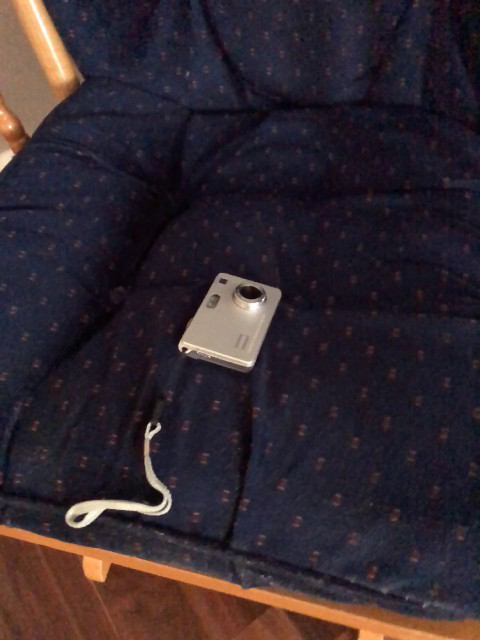

In [24]:
idx = 10
experiment.load_hdf5_file()
query_im=experiment.get_image(idx, train=False)
query_im

In [25]:
query_im.size

(480, 640)

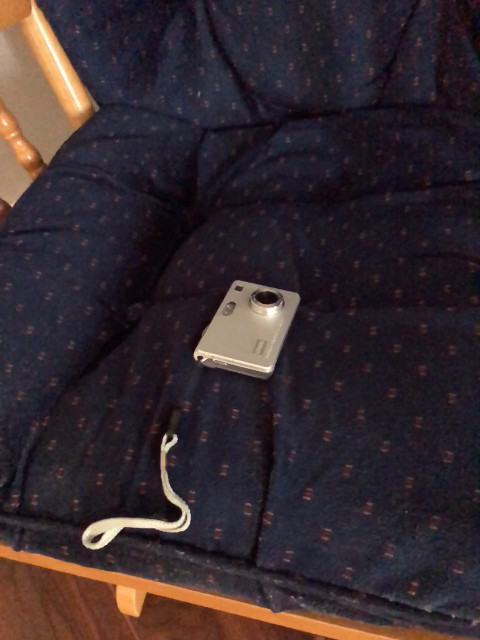

In [26]:
#match_idx, score = zsp.find_match_idx(idx, experiment.embeddings, experiment.train_embeddings,0, score=True)
match_idx= matches[idx]
res_im=experiment.get_image(match_idx, train=False)
res_im

In [27]:
match_idx

42525

In [28]:
experiment.train_info_df.iloc[match_idx]

category_id                         6
uid                hdf5_cup/01497_235
category                          cup
sequence_uid                cup/01497
frame                             NaN
video_id                          NaN
object_id                         NaN
batch_number                      NaN
sequence_number                   NaN
filepath                          NaN
filepath_full                     NaN
Name: 42525, dtype: object

In [69]:
experiment.info_df.iloc[idx]

category_id                          0
uid                hdf5_bike/00022_189
category                           NaN
sequence_uid                bike/00022
frame                              NaN
video_id                           NaN
object_id                          NaN
batch_number                       NaN
sequence_number                    NaN
filepath                           NaN
filepath_full                      NaN
Name: 91, dtype: object

In [70]:
#train_info_df.iloc[match_idx]["filepath_full"], info_df.iloc[idx]["filepath_full"]

In [71]:
from PIL import ImageDraw
points_3d_result = zsp.get_bounding_box(idx, match_idx, experiment, adjust_scale=True)

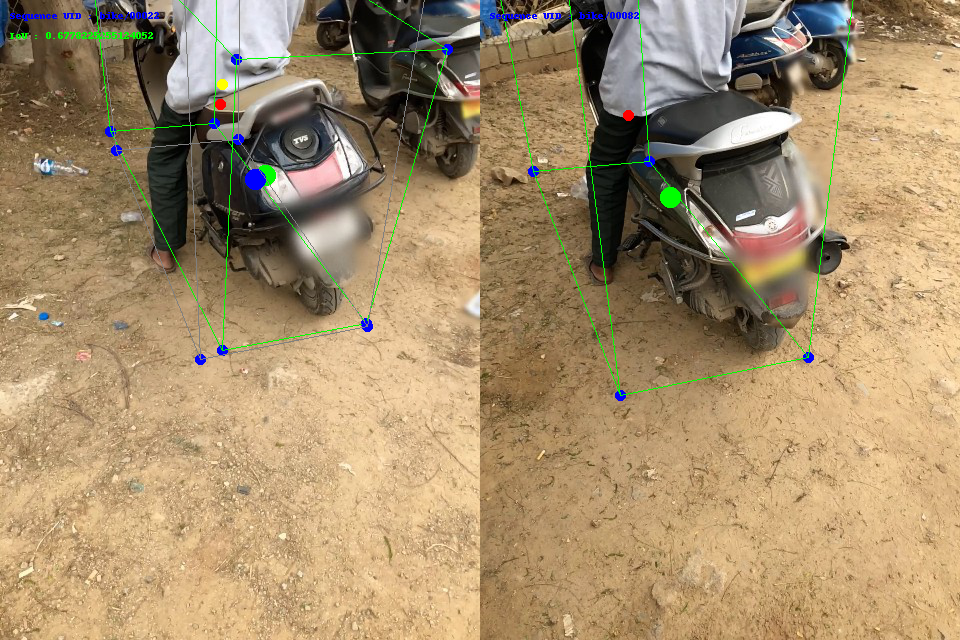

In [72]:
def get_preview(query_idx, match_idx):
    #query_im=Image.open(info_df.iloc[query_idx]["filepath_full"])
    canevas = Image.new('RGB', (480*2, 640))
    points_3d_result = zsp.get_bounding_box(query_idx, match_idx, experiment, adjust_scale=True)
    #points_3d_result=points_3d_result1
    query_im = experiment.get_image(query_idx, train=False)
    result_im = experiment.get_image(match_idx, train=True)
    #query_camera = zsp.get_camera(info_df, query_idx)
    query_intrinsics = experiment.get_intrinsics(query_idx, train=False)
    points_2d_query, points_3d_query = experiment.get_points(query_idx, train=False)
    points_2d_px_query = geo.points_2d_to_points2d_px(points_2d_query, 480, 640)
    
    points_2d_result_raw, points_3d_result_raw = experiment.get_points(match_idx, train=True)
    points_2d_px_result_raw = geo.points_2d_to_points2d_px(points_2d_result_raw, 480, 640)
    geo.draw_bbox(result_im,points_2d_px_result_raw)
    
    query_intrinsics = geo.scale_intrinsics(query_intrinsics, 1/3, 1/3)
    points2d_px_result = geo.project_3d_to_2d(points_3d_result, query_intrinsics)
    points2d_px_query = geo.project_3d_to_2d(points_3d_query, query_intrinsics)
    iou = zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result))
    d = ImageDraw.Draw(query_im)
    iou_color = (255,0,0,255)
    if iou > 0.5:
        iou_color = (0,255,0,255)
    d.text((10,30),f"IoU : {iou}", fill=iou_color)
    
    query_sequence_uid = experiment.get_sequence_uid(query_idx, train=False)
    d.text((10,10),f"Sequence UID : {query_sequence_uid}", fill=(0,0,255,255))
    
    d = ImageDraw.Draw(result_im)
    result_sequence_uid = experiment.get_sequence_uid(match_idx, train=True)
    d.text((10,10),f"Sequence UID : {result_sequence_uid}", fill=(0,0,255,255))
    
    #print()
    geo.draw_bbox(query_im,points2d_px_result, line_color=iou_color)
    geo.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128), pixel_center_color=(0,0,255),object_center_color=(255,255,0))
    canevas.paste(query_im)
    canevas.paste(result_im, (480,0))
    return canevas
display.display(get_preview(idx, match_idx))

In [73]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


slider = widgets.IntSlider(min=0, max=10000, step=1, value=10)

def f(x):
    idx =x 
    #match_idx, score = zsp.find_match_idx(idx, experiment.embeddings, experiment.train_embeddings,0, score=True)
    match_idx = matches[idx]
    print(idx, match_idx)
    points_3d_result = zsp.get_bounding_box(idx, match_idx, experiment, adjust_scale=True)
    display.display(get_preview(idx, match_idx))
interact(f, x=slider)


interactive(children=(IntSlider(value=10, description='x', max=10000), Output()), _dom_classes=('widget-intera…

<function __main__.f(x)>

In [80]:
experiment.info_df["sequence_uid"] = experiment.info_df["uid"].str.extract("hdf5_(\w+/\d+)_")
valid_sequences= sorted(list(experiment.info_df["sequence_uid"].unique()))
valid_sequence = valid_sequences[500]
valid_sequence

'cereal_box/01020'

In [81]:
from natsort import natsorted
df = experiment.info_df.query(f"sequence_uid=='{valid_sequence}'")
df["idx"]=df.index
df = df.set_index("uid")
df = df.reindex(index=natsorted(df.index))


/home/raphael/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



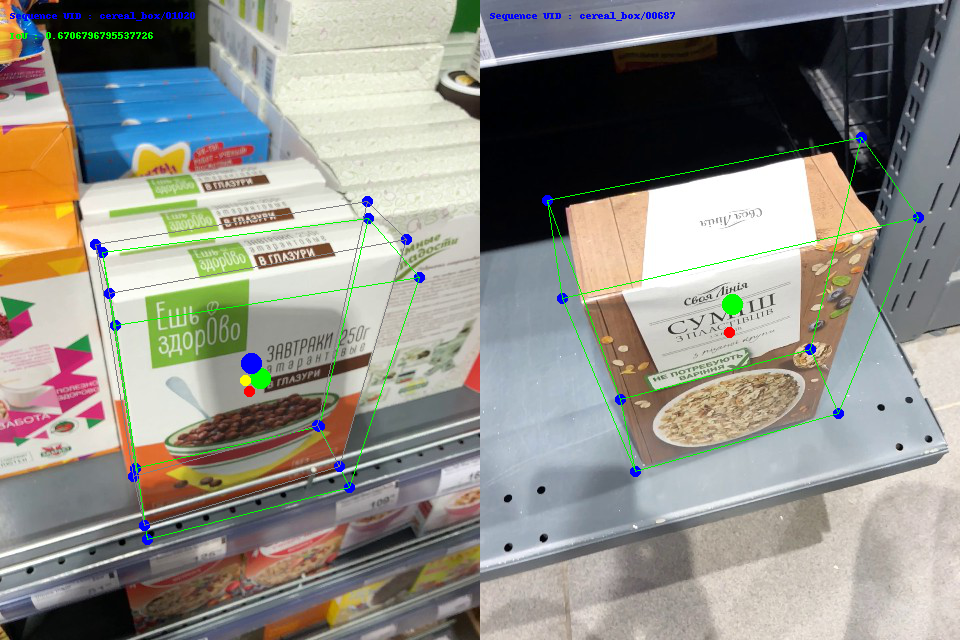

In [82]:
import time
idxs = list(df["idx"])
import cv2

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 5.0, (480*2,640))

for idx in idxs:
    match_idx = matches[idx]
    points_3d_result = zsp.get_bounding_box(idx, match_idx, experiment, adjust_scale=True)
    display.clear_output(wait=True)
    preview_image = get_preview(idx, match_idx)
    display.display(preview_image)
    bgr_image = cv2.cvtColor(np.array(preview_image), cv2.COLOR_RGB2BGR)
    out.write(bgr_image)
    time.sleep(0.25)

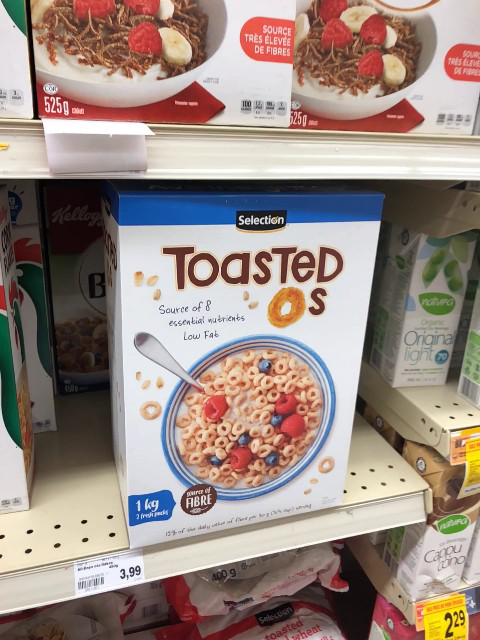

In [75]:
experiment.get_image(364121, train=True)

In [234]:
def build_df(points_3d, name="default"):
    df = pd.DataFrame(points_3d).rename(columns={0:"x", 1:"y", 2:"z"})
    df["name"]=name
    df = df.append(pd.Series([0,0,0,"camera"], index=df.columns ), ignore_index=True)
    return df
points3d_df = build_df(points_3d_query, "query")
points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result))

0.43636998013146266

In [40]:
query_camera = zsp.get_camera(info_df, idx)

#result_camera = zsp.get_camera(train_info_df, train_idx)
#result_intrinsics = zsp.get_intrinsics(result_camera)
#result_intrinsics = zsp.scale_intrinsics(result_intrinsics, 0.25, 0.25)

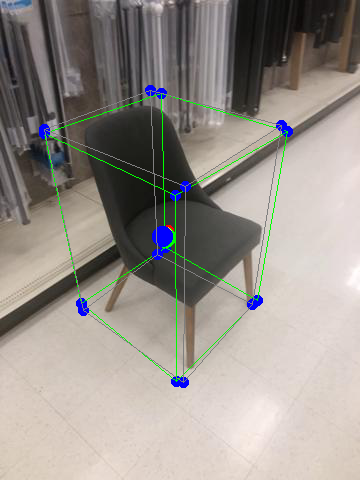

In [19]:
result_bbox = zsp.get_bbox(points2d_px_result, query_im.width, query_im.height)
query_bbox = zsp.get_bbox(points2d_px_query, query_im.width, query_im.height)

In [20]:

scale = zsp.get_bbox_area(query_bbox) / zsp.get_bbox_area(result_bbox)
scale

1.1055183682457537

In [21]:
scale = zsp.get_smooth_scale_factor(points_3d_query, points_3d_result_centered, query_intrinsics, 2)
scale

1.052759184122877

In [22]:
points3d_scaled = zsp.snap_to_plane(zsp.scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, center_ray, obj_radius = obj_radius*scale)
points3d_scaled

array([[-0.01861803, -0.04315793, -1.6003138 ],
       [ 0.31463464, -0.44888429, -1.84036112],
       [ 0.55302056, -0.01048551, -1.52644773],
       [-0.33932577, -0.44888345, -1.3437465 ],
       [-0.10094086, -0.01048463, -1.02983313],
       [ 0.06370481, -0.07583126, -2.17079547],
       [ 0.30208973,  0.36256757, -1.85688223],
       [-0.5902556 , -0.07583041, -1.67418085],
       [-0.35187069,  0.36256841, -1.36026761]])

In [23]:
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))

0.7854928286905482

0 0.8131235878161949
1 0.8180783930713781
2 0.8191050178889032


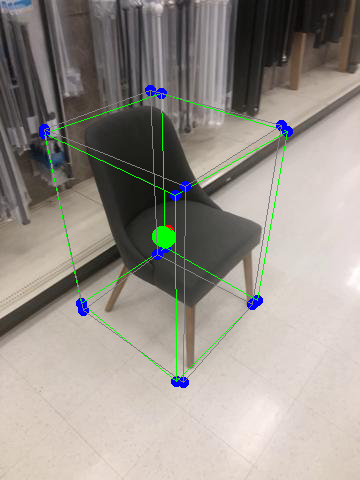

In [26]:
scale = zsp.get_smooth_scale_factor(points_3d_query, points3d_scaled, query_intrinsics, 2)
for i in range(0,3):
    obj_radius = zsp.get_dist_from_plane(plane_normal_query, plane_center_query, points3d_scaled[0])
    points3d_scaled = zsp.snap_to_plane(zsp.scale_3d_bbox(points3d_scaled, scale), plane_normal_query, plane_center_query, center_ray, obj_radius = obj_radius*scale)
#    points3d_scaled = snap_to_plane_px(scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, plane_normal_result, plane_center_result, obj_radius = obj_radius*scale)
    scale = zsp.get_smooth_scale_factor(points_3d_query, points3d_scaled, query_intrinsics, 2)
    print(i, zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled)))
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
points2d_px_result = zsp.project_3d_to_2d(points3d_scaled, query_intrinsics)
points2d_px_query = zsp.project_3d_to_2d(points_3d_query, query_intrinsics)
zsp.draw_bbox(query_im,points2d_px_result)
zsp.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128))

In [27]:
points3d_df = build_df(points_3d_query, "query")
#points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
points3d_df = points3d_df.append(build_df(points3d_scaled, "points3d_scaled"))
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()